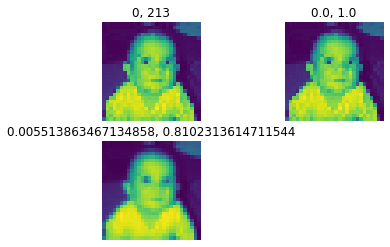

In [6]:
# Read image (two options)
# options to normalize values (0,255 or 0,1)
# force into more than int8
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import numpy as np

from nc_suite import plot_images
size = (28,28)

img_cv2 = np.array(cv2.resize(cv2.imread("data/test/3.jpg",0), size))

img_sk = imread("data/test/3.jpg",0)
img_sk = rgb2gray(img_sk)
img_sk = resize(img_sk, size)

img_cv2_2 = img_cv2 / np.max(img_cv2) # always do this for everything else to make sense

imgs = [img_cv2,img_cv2_2,img_sk]
labels = [f'{np.min(img)}, {np.max(img)}' for img in imgs]

plot_images(imgs, labels)

In [2]:
# try out a few different weightings
# + things like set diagonal to 0 on weights.. or set 0 on laplacian to see which makes differences..
# different laplace calculate methods?
from nc_suite import *
from tqdm import tqdm

radii = [1] # 784//4, 10

methods = [manual_weight_abs2] # manual_weights_binary2, weight_int
# posts = [zeroes]

outputs = []
for img in imgs:
    for radius in radii:
        temp_out = []
        for method in methods:
            temp_out.append(method(img, radius))
        temp_out.append(intens_posit_wm(img))
        # for post in posts:
        for temp in temp_out:
            outputs.append(temp)

/Users/garth/Desktop/DDN/nc_suite.py:272: RuntimeWarning: overflow encountered in ubyte_scalars
  W[u][v] = W[v][u] = np.abs(I[u] - I[v]) # Symmetric


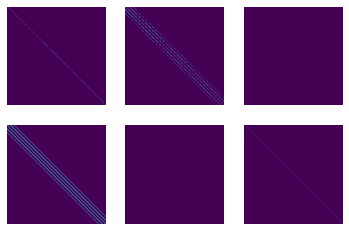

In [3]:
plot_images(outputs)

In [ ]:
def get_laplace(W, num=0, W_zerod=True, L_zerod=False):
    if W_zerod:
        np.fill_diagonal(W,0)
    d = np.sum(W, 1)
    
    if num == 0: # expensive
        sqrt_D_inv = np.diag(np.reciprocal(np.sqrt(d), where=d!=0)) # assumes D is 1 dimensional vector
        D = np.diag(d)
        L = sqrt_D_inv @ (D - W) @ sqrt_D_inv
        
    if num == 1: # cheap
        shift = 0.5
        
        sqrt_D = np.diag(np.sqrt(d)) # assumes D is 1 dimensional vector
        L = sqrt_D @ np.linalg.inv(D * (1-shift) - W) @ sqrt_D # no matmul for the D multiplied by constant factor
    
    if num == 2: # non symmetrically normalized
        D = np.diag(d)
        L = D-W
        
    if L_zerod:
        np.fill_diagonal(L, 0)
    return L

In [4]:
# cut
# 2-3 different solvers (eig, eigh, something else lobpcg would be nice)
# generalized vs normal? what is not generalized called idk

for output in outputs:
    for i in range(3):
        get_laplace(output, i, True, False)

# calculate D
# calculate L
# compute 2nd smallest eigenvector

# plot outputs :)